# Python for Geospatial Analysis PhD Course 
# AAU CPH, Spring 2020
## Final assignment Jupyter Notebook

### Raster analysis

**1. Write a function that plots the projected total and urban population from 2010 to 2100 for a selected country as a line chart. The attached countries.tif contains the country ID for each cell; this list shows which ID is which country**

**Raster exploration** 🤓

In order to make raster calculations, we have to make sure the rasters we are dealing with have the same specifications which are: CRS (coordinate reference system), height & width #(dimensions), size(number of cells), count (number of bands), nodatavals (Nan values). All this included in raster.meta

In [2]:
import os #paths
import rasterio #raster
import numpy as np #arrays

#We open the raster
path = r"countries.tif"
c_raster = rasterio.open(path)
c_raster.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': -99.0,
 'width': 2880,
 'height': 1117,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.125, 0.0, -180.0,
        0.0, -0.125, 83.75)}

**SS4P Population tifs**

We need to check the properties of all the other population rasters, so we will use to define some functions:

In [3]:
#We define a function for reading the population tifs which will create a raster list
def readtifs (folder, start, end, step):   
    rasters = []
    #Access to the files on a loop based on the year
    for i in range(start,end,step):            
        path = folder+str(i)+".tif"
        raster = rasterio.open(path)
        rasters.append(raster)   
    return rasters

#We define a function to check metadata of the rasters contained on a raster list
def check_raster(raster_list):
    for i in range(len(raster_list)):
        for j in range(len(raster_list)):
            if i < j:
                if raster_list[i].meta == raster_list[j].meta:
                    continue
                else:
                    print(f"Metadata are different between raster {i} and raster {j}")
    
#We define the directories of the raster folders
urban_folder = "SS4_Inequality_Urban\ssp4urb"
total_folder = "SS4_Inequality_Total\ssp4_"

#We check both urban and total raster lists 
urban_raster = readtifs(urban_folder, 2010, 2101, 10)
check_raster(urban_raster)

total_raster = readtifs(total_folder, 2010, 2101, 10)
check_raster(total_raster)

print("Success, rasters metadata coincide")

Success, rasters metadata coincide


Now let's compare population rasters metadata with the countries ID raster:

In [4]:
urban_raster[0].meta == total_raster[0].meta == c_raster.meta

False

Oooops, lets see what is wrong:

In [5]:
(urban_raster[0].meta, c_raster.meta)

({'driver': 'GTiff',
  'dtype': 'int32',
  'nodata': 2147483647.0,
  'width': 2880,
  'height': 1117,
  'count': 1,
  'crs': CRS.from_epsg(4326),
  'transform': Affine(0.125, 0.0, -180.0,
         0.0, -0.125, 83.749999999915)},
 {'driver': 'GTiff',
  'dtype': 'float64',
  'nodata': -99.0,
  'width': 2880,
  'height': 1117,
  'count': 1,
  'crs': CRS.from_epsg(4326),
  'transform': Affine(0.125, 0.0, -180.0,
         0.0, -0.125, 83.75)})

The sizes are the same along with the respective CRS, which means it makes sense to compute the values from them. However, we also see dtype and nodatavals are different. As we intend to sum the population rasters, we need to fix the nodatavals of the rasters and we usually do that in ArcMap by setting no data values to 0. For this we will investigate the mask property that we will use.

In [6]:
#Masked property for array
import numpy.ma as ma
x = np.array([1, 2, 3, -1, 5])
mx = ma.masked_array(x, mask=[0, 0, 0, 1, 0])
x.sum(), mx.sum()

(10, 11)

One masks values under the presence of invalid data, it indicates what values are not valid for further operations, lets check what are the fill values for a raster when is masked 

In [7]:
#Check the first masked raster in urban raster lists
f = urban_raster[0].read(1, masked = True)
f

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=2147483647)

We can see that the fill value equals to the 'nodata' value, therefore we will use the mask property for the calculations hereof. And, by defining the following function, we arrive to the fulfilment of the first part of the assignment where we will calculate the total and urban population for a given country and then plot the values in a 2D line with years as X-axis and populations as Y-axis. The function uses a country_ID as an argument, this country ID can be obtained [here](https://en.wikipedia.org/wiki/ISO_3166-1_numeric). For explemplifyinf this, we will use *Ecuador with ID = 218*

,Year,Urban,Total
0,2010,9660985,14500377
1,2020,12088614,16344221
2,2030,14031581,17729841
3,2040,15443462,18615041
4,2050,16298626,18966576
5,2060,16599986,18827960
6,2070,16464672,18306747
7,2080,15960657,17467548
8,2090,15169942,16402377
9,2100,14202246,15197676


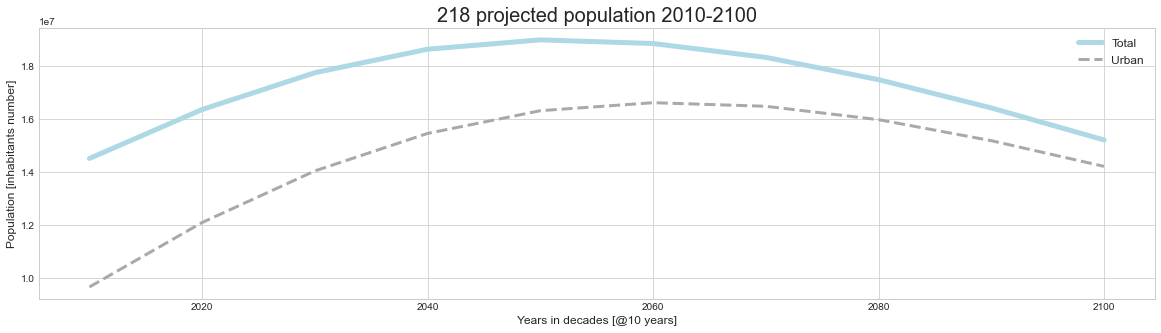

In [11]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline 
mpl.style.use('seaborn-whitegrid')
import pandas as pd

def projected (country_ID):
    #This code will create a mask for the selected country
    countries = c_raster.read(1, masked = True)
    country_mask = countries == country_ID

    #Here, we will sum up the population contained in country_mask using unmasked raster data
    x = list(range(2010, 2101, 10))
    y1 = []
    for raster in urban_raster:
        population = raster.read(1, masked = True)
        y1.append(population[country_mask].sum())

    y2 = []
    for raster in total_raster:
        population = raster.read(1, masked = True)
        y2.append(population[country_mask].sum())
  
    
    #Plot design for both lists
    fig, lns = plt.subplots(figsize=(20, 5))
    lns.plot(x,y2,label='Total', color='lightblue', linewidth=5) 
    lns.plot(x,y1,'k--',label='Urban', color='darkgray', linewidth=3)
    
    legend = lns.legend(shadow=True, fontsize='large', loc=0)
    lns.set_ylabel('Population [inhabitants number]',fontsize=12)
    lns.set_xlabel('Years in decades [@10 years]',fontsize=12)
    lns.set_title(f"{country_ID} projected population 2010-2100", fontsize=20)
    
    return pd.DataFrame(data=list(zip(x,y1,y2)), columns=["Year", "Urban", "Total"])
    
country_ID = 218
df = projected(country_ID)
df

Scary projection for poor urban saturated areas as total gets closer to urban, specially for millenial life expectancy where apparently it peaks 🤔 I wonder how rural is rural if its represented by the difference between these two. The spatial analysis of that rurality will be my next step with these dataset but for now lets concentrate on the assignment.

### Raster analysis

**2. Generate a global raster that shows only the cells that are projected to lose population, and indicates how much the population in those cells is projected to decline between 2010 and 2100**

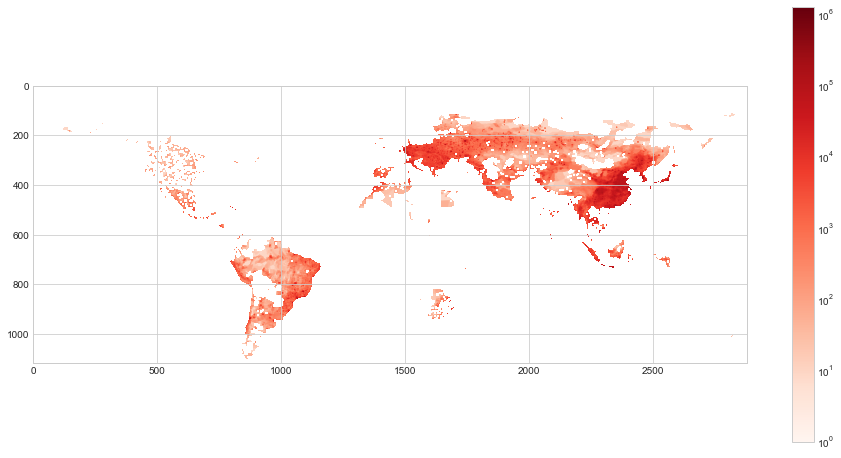

In [12]:
from matplotlib.colors import LogNorm

#Create an array reading the first and last raster in total_raster list and return the difference only if positive
pop_diff = total_raster[0].read(1, masked = True) - total_raster[-1].read(1, masked = True) # nan not taken
pops = pop_diff.copy() #[pop_diff > 0] #if positive, population decreases
pops[pops<0] = 0 

plt.figure(figsize=(16,8))
imgplot = plt.imshow(pops, norm=LogNorm(), cmap='Reds')
plt.colorbar()
plt.show()

### Spatial autocorrelation

**Spatial autocorrelation** 🤓

**1. Download a shapeﬁle of the world from naturalearthdata.com and perform a left join with the attached under5mortality.csv , which contains child mortality rates for each country in the world. The join should be done on the ISO_A3 column in the shapeﬁle and the ISO column in the CSV, respectively.**

First we will download the data from the url given, unzip it and read the files with the help of geopandas library, the we will read the text file and perform the left join:

In [13]:
import zipfile
import urllib.request
import geopandas as gpd
import pandas as pd

#Download and unzip the folder containing the shapefile of the world from naturalearthdata.com
if os.path.exists('ne_110m_admin_0_countries.shp'):
    print("Shapefile already downloaded and unzipped")
else:
    urllib.request.urlretrieve("https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/110m/cultural/ne_110m_admin_0_countries.zip", "Files/World.zip")
    zf = zipfile.ZipFile("World.zip")
    zf.extractall()
    zf.close()
    os.remove("World.zip") # clean up
    print("Download and unzip complete")

fp = 'ne_110m_admin_0_countries.shp'
data = gpd.read_file(fp)

#Read the child under 5 mortality csv file
path = r"under5mortality.csv"
df = pd.read_csv(path, index_col=0)

#Perform a left joint shapefile to the csv 
shape_mortality_data = pd.merge(data,df, left_on='ISO_A3', right_on='ISO', how='left')



Shapefile already downloaded and unzipped


Lets print the data:

In [14]:
shape_mortality_data.head()

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,ADMIN,ADM0_A3,...,NAME_PT,NAME_RU,NAME_SV,NAME_TR,NAME_VI,NAME_ZH,geometry,ISO,Name,ChildMortality
0,Admin-0 country,1,6,Fiji,FJI,0,2,Sovereign country,Fiji,FJI,...,Fiji,Фиджи,Fiji,Fiji,Fiji,斐濟,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",FJI,Fiji,25.3
1,Admin-0 country,1,3,United Republic of Tanzania,TZA,0,2,Sovereign country,United Republic of Tanzania,TZA,...,Tanzânia,Танзания,Tanzania,Tanzanya,Tanzania,坦桑尼亚,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",TZA,United Republic of Tanzania,54.0
2,Admin-0 country,1,7,Western Sahara,SAH,0,2,Indeterminate,Western Sahara,SAH,...,Saara Ocidental,Западная Сахара,Västsahara,Batı Sahra,Tây Sahara,西撒哈拉,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",NaN,NaN,NaN
3,Admin-0 country,1,2,Canada,CAN,0,2,Sovereign country,Canada,CAN,...,Canadá,Канада,Kanada,Kanada,Canada,加拿大,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",CAN,Canada,5.1
4,Admin-0 country,1,2,United States of America,US1,1,2,Country,United States of America,USA,...,Estados Unidos,Соединённые Штаты Америки,USA,Amerika Birleşik Devletleri,Hoa Kỳ,美国,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",USA,United States,6.6


Now lets plot the data in a map, and to do that we will use a quartile classification for displaying the ChildMortality attribute of the shapefile:

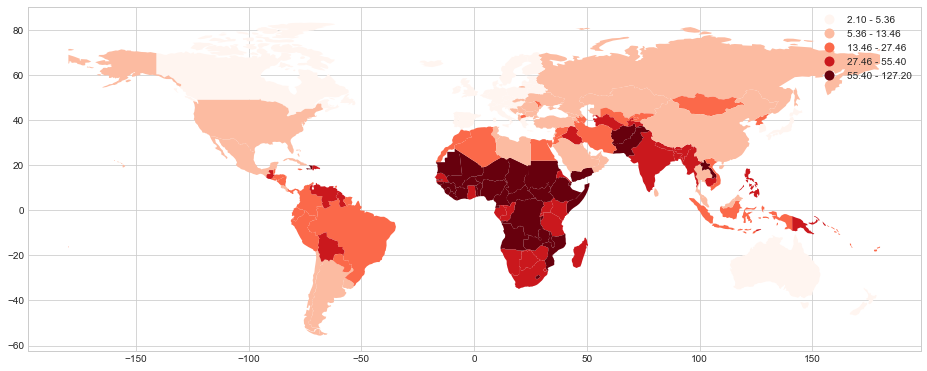

In [15]:
shape_mortality_data.plot(column="ChildMortality", figsize=(16, 8), 
                          cmap='Reds', legend = True, scheme ='quantiles')

**2. Calculate the spatial weights matrix for the world based on border neighborhood and use the weights to calculate Moran's I for child mortality.** 

To do this we will first obtain the Queen weights for spatial autocorrelation:

In [16]:
import libpysal 
from libpysal import weights

shape_mortality_data["ChildMortality"].fillna(shape_mortality_data["ChildMortality"].mean(), inplace=True)

queen_weights = weights.Queen.from_dataframe(shape_mortality_data)
 
pd.DataFrame(queen_weights.full()[0], 
             index=shape_mortality_data['ISO'],
             columns=shape_mortality_data['ISO'],
            ).astype(int)

C:\Users\diana\AppData\Local\Continuum\anaconda3\envs\geoanalysis\lib\site-packages\libpysal\weights\weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 25 disconnected components.
 There are 21 islands with ids: 0, 19, 20, 22, 23, 45, 46, 47, 78, 89, 134, 135, 136, 137, 138, 140, 144, 147, 155, 159, 175.
  warnings.warn(message)


ISO,FJI,TZA,NaN,CAN,USA,KAZ,UZB,PNG,IDN,ARG,...,NaN,UGA,RWA,BIH,MKD,SRB,MNE,NaN,TTO,SSD
ISO,,,,,,,,,,,,,,,,,,,,,
FJI,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TZA,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
NaN,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CAN,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
USA,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRB,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,1,1,0,0
MNE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,1,0,0
NaN,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,1,0,0,0


And now we will calculate the moran index for the weights calculated: 

In [17]:
from pysal.explore import esda

moran = esda.Moran(shape_mortality_data['ChildMortality'], queen_weights)
print(moran.I)
print(moran.p_sim)

('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 19, ' is an island (no neighbors)')
('WARNING: ', 20, ' is an island (no neighbors)')
('WARNING: ', 22, ' is an island (no neighbors)')
('WARNING: ', 23, ' is an island (no neighbors)')
('WARNING: ', 45, ' is an island (no neighbors)')
('WARNING: ', 46, ' is an island (no neighbors)')
('WARNING: ', 47, ' is an island (no neighbors)')
('WARNING: ', 78, ' is an island (no neighbors)')
('WARNING: ', 89, ' is an island (no neighbors)')
('WARNING: ', 134, ' is an island (no neighbors)')
('WARNING: ', 135, ' is an island (no neighbors)')
('WARNING: ', 136, ' is an island (no neighbors)')
('WARNING: ', 137, ' is an island (no neighbors)')
('WARNING: ', 138, ' is an island (no neighbors)')
('WARNING: ', 140, ' is an island (no neighbors)')
('WARNING: ', 144, ' is an island (no neighbors)')
('WARNING: ', 147, ' is an island (no neighbors)')
('WARNING: ', 155, ' is an island (no neighbors)')
('WARNING: ', 159, ' is an island (no neig

Islands dont have neighbors thus the warning. We will also check the K-nearest neighbor with a k of 2 🤓

In [18]:
#KNN weight
w_k2 = weights.KNN.from_dataframe(shape_mortality_data, k=2)
moran = esda.Moran(shape_mortality_data['ChildMortality'], w_k2)
print(moran.I)
print(moran.p_sim)

0.678698254663851
0.001


C:\Users\diana\AppData\Local\Continuum\anaconda3\envs\geoanalysis\lib\site-packages\libpysal\weights\weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 10 disconnected components.
  warnings.warn(message)


Now we will see how the correlations look like in the map:

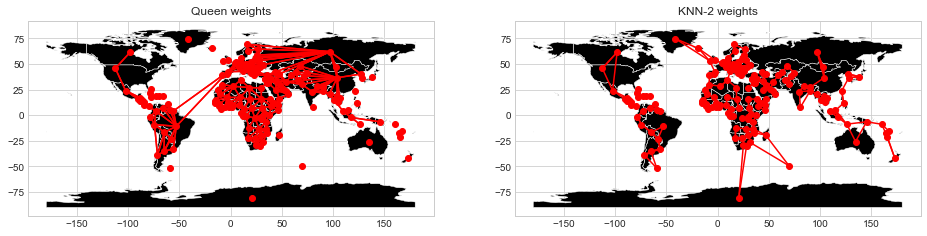

In [19]:
f, axs = plt.subplots(1, 2, figsize=(16, 8))

shape_mortality_data.plot(color='k', ax=axs[0], 
        edgecolor='w', linewidth=0.5)
queen_weights.plot(shape_mortality_data, ax=axs[0], color='red')
axs[0].set_title('Queen weights')

shape_mortality_data.plot(color='k', ax=axs[1], 
        edgecolor='w', linewidth=0.5)
w_k2.plot(shape_mortality_data, ax=axs[1], color='red')
axs[1].set_title('KNN-2 weights')

plt.show()

And finally, we will get to see the relation of this autocorrelation in a Moran Scatterplot:

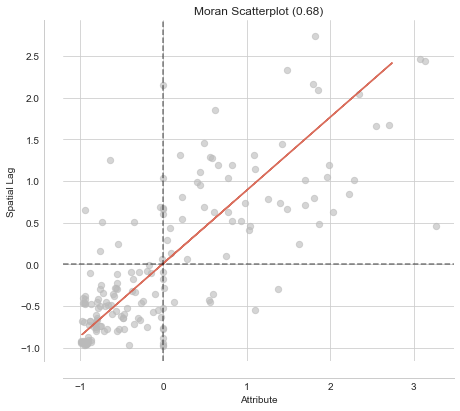

In [20]:
from splot.esda import moran_scatterplot
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

I have to say I have followed [Dani Arribas-Bel](http://darribas.org) documentation and tutorials, I think they have complemented quite well the course from AAU.